## Solve the inverse design problem with Design-GenNO (Target response field ${u}_d$)

## (1) Load the trained model

a_true torch.Size([1, 1024, 1]) x_obs torch.Size([256, 2])
ux_obs torch.Size([1, 256, 1]) uy_obs torch.Size([1, 256, 1])
The shape of x_in: torch.Size([4096, 2]) x_left&right: torch.Size([300, 2]) x_bottom&up: torch.Size([300, 2])


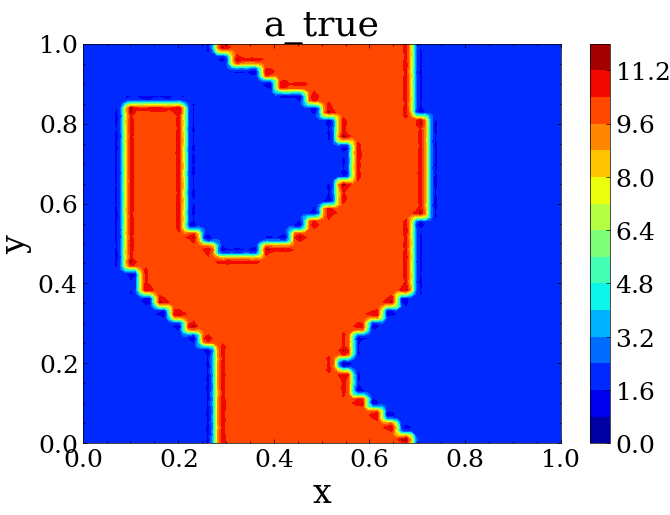

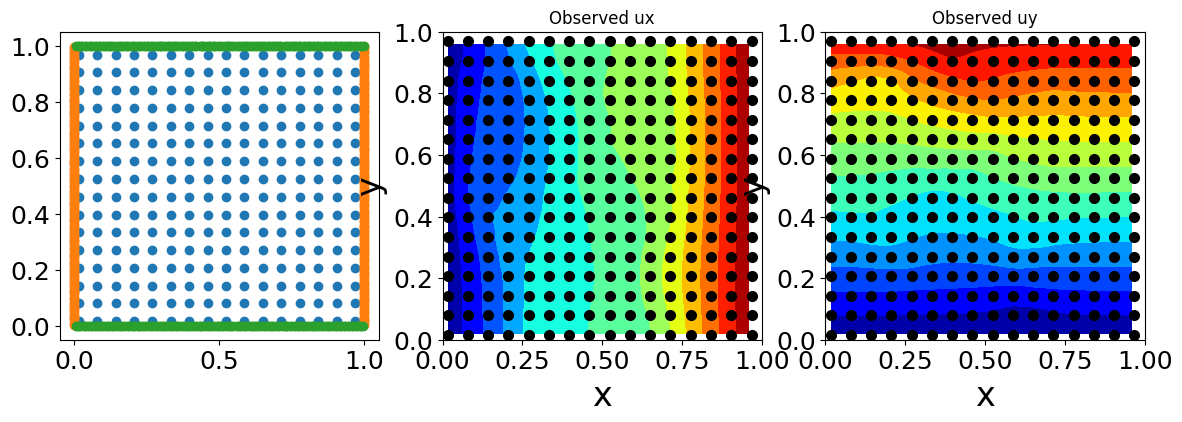

The trained model has been loaded !!!!


In [1]:
import numpy as np
import torch 
import torch.nn as nn
import h5py
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
tag = 'MixedDriven'; task = 'task_temp';
res_coe, res_sol = 32, 64
mu = [10., 2.] # [phase=1, phase=0]
######################################
# Load observation data
######################################
from Utils.utils import *
class Get_High_Resolution_a(object):

    def __init__(self, res=res_coe):
        super(Get_High_Resolution_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x_mesh, a):
        ''' 
        Input:
            x_mesh: size(n_batch, n_mesh, 2)
            a: size(n_batch, nx*ny)
        Result:
            a_new: size(n_batch, n_mesh)
        '''
        x_loc = torch.floor(x_mesh[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x_mesh[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        a_new = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return a_new
#
with h5py.File('./Dataset/inverse_target_temp.mat', 'r') as data:
    a_true = np2tensor(np.array(data["coe"]), dtype).reshape(1, -1, 1)
    a_true[a_true==1.] = mu[0]; a_true[a_true==0.] = mu[1];
    ux_obs = np2tensor(np.array(data["Tx_target"]), dtype).reshape(1, -1, 1)
    uy_obs = np2tensor(np.array(data["Ty_target"]), dtype).reshape(1, -1, 1)
    x_obs = np2tensor(np.array(data["sensors"]), dtype)
#
print('a_true', a_true.shape, 'x_obs', x_obs.shape)
print('ux_obs', uy_obs.shape, 'uy_obs', uy_obs.shape)
######################################
# Generate boundary data
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
x_in = pointGen.inner_point(res_sol, method='mesh')
a_in = Get_High_Resolution_a()(x_in, a_true).reshape(1,-1)
#
N_bd_each_edge = 150
x_bd = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
x_lr = x_bd[0:2*N_bd_each_edge]
x_bu = x_bd[2*N_bd_each_edge:]
print('The shape of x_in:', x_in.shape, 'x_left&right:', x_lr.shape, 'x_bottom&up:', x_bu.shape)

######################################
from Utils.PlotFigure import Plot
Plot.show_2d(x_in, a_in[0], 'a_true', lb =0.)
#####################################
from scipy.interpolate import griddata
#
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
mesh = np.meshgrid(np.linspace(0., 1., 100), np.linspace(0., 1., 100))
x_plot, y_plot = mesh[0], mesh[1]
#
axes[0].scatter(x_obs[:,0], x_obs[:,1], label='meshgrids', linewidth=1.)
axes[0].scatter(x_lr[:,0], x_lr[:,1], label='left & right')
axes[0].scatter(x_bu[:,0], x_bu[:,1], label='bottom & up')
# axes[0].legend()
#
z_plot = griddata((x_obs[:,0], x_obs[:,1]), np.ravel(ux_obs), (x_plot, y_plot), method='cubic')
cntr = axes[1].contourf(x_plot, y_plot, z_plot, levels=14, cmap='jet')
axes[1].scatter(x_obs[:,0], x_obs[:,1], color='k', linewidth=2.)
axes[1].set_title('Observed ux', fontsize=12)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
#
z_plot = griddata((x_obs[:,0], x_obs[:,1]), np.ravel(uy_obs), (x_plot, y_plot), method='cubic')
cntr = axes[2].contourf(x_plot, y_plot, z_plot, levels=14, cmap='jet')
axes[2].scatter(x_obs[:,0], x_obs[:,1], color='k', linewidth=2.)
axes[2].set_title('Observed uy', fontsize=12)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
#
plt.show()

# #####################################
# # Load the trained model
# #####################################
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_list, activation, dtype):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_list, activation, dtype) 
        
    def forward(self, feat):
        '''
        Input:
            feat: size(batch_size, a_size)
        Return:
            output: size(?, beta_size) -> size(? beta_size)
        '''
        beta = self.encoder(feat)
        beta = torch.tanh(beta)
        return beta
        
################ Load 
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_{tag}/', name=f'model_dgno_final')
#
print('The trained model has been loaded !!!!')

## (2) Define the objective function

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
class mollifer_x(object):

    def __inint__(self):
        super(mollifer_x, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        xx, yy = x[...,0], x[...,1]
        u = u * torch.sin(np.pi * xx) + torch.sin(np.pi/2 * xx)
        return u.unsqueeze(-1)
#
class mollifer_y(object):

    def __inint__(self):
        super(mollifer_y, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        xx, yy = x[...,0], x[...,1]
        u = u * torch.sin(np.pi * yy) + torch.sin(np.pi/2 * yy)
        return u.unsqueeze(-1)
#
def a_sample(a_prob, samples=25):
    '''Reparameterization trick for Multivariate Bernoulli: https://davidstutz.de/bernoulli-variational-auto-encoder-in-torch/
    a_prob: size(n_batch, mesh_size)
    '''
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*(mu[0]-mu[1]) + mu[1]
    
    return a

###############################
class LossClass(object):

    def __init__(self, model_beta, device, dtype):
        super(LossClass, self).__init__()
        ''' '''
        self.device = device
        self.dtype = dtype
        #
        self.mollifer_x = mollifer_x()
        self.mollifer_y = mollifer_y()
        #
        self.model_beta = model_beta
        self.model_a = model_trained['a']
        self.model_ux = model_trained['ux']
        self.model_uy = model_trained['uy']
        self.model_sx1 = model_trained['sx1']
        self.model_sx2 = model_trained['sx2']
        self.model_sy1 = model_trained['sy1']
        self.model_sy2 = model_trained['sy2']
        #######################
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)
        #
        self.n_sample = 1
        self.ones = torch.ones((1,1)).to(device)

    def Loss_pde(self, nc=100):
        ''' The PDE loss'''
        n_batch = self.n_sample
        beta = self.model_beta(self.ones).view(n_batch, 128)
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        nc = xc.shape[0]
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1, 1) # size(nc*n_grid, 1)
        dv = (self.dv_dr / R).reshape(-1, 2) # size(nc*n_grid, 2)
        ################ model prediction ###########
        # a_detach: size(n_batch, nc*n_grid) -> (n_batch, nc*n_grid, 1)
        a_prop = nn.Sigmoid()(model_trained['a'](x.detach(), beta))
        a_detach = a_sample(a_prop).unsqueeze(-1)
        ############### The x-direction
        # ux: size(n_batch, nc*n_grid) -> size(n_batch, nc*n_grid)
        ux = self.model_ux(x, beta)
        ux = self.mollifer_x(ux, x)
        # sx: size(n_batch, nc*n_grid, 2)
        sx = torch.stack([self.model_sx1(x, beta), self.model_sx2(x, beta)], dim=-1)
        # dux: size(n_batch, nc*n_grid, 2)
        dux = grad(inputs=x, outputs=ux, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
        #
        res1 = torch.sum( (sx - a_detach * dux)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
        res1 = torch.mean(res1, dim=-1) # size(n_batch, nc)
        res2 = torch.sum(sx * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        res2 = torch.mean(res2, dim=-1)**2 # size(n_batch, nc)
        ############### The y-direction
        # uy: size(n_batch, nc*n_grid) -> size(n_batch, nc*n_grid, 1)
        uy = self.model_uy(x, beta)
        uy = self.mollifer_y(uy, x)
        # sy: size(n_batch, nc*n_grid, 2)
        sy = torch.stack([self.model_sy1(x, beta), self.model_sy2(x, beta)], dim=-1)
        # duy: size(n_batch, nc*n_grid, 2)
        duy = grad(inputs=x, outputs=uy, grad_outputs=torch.ones_like(uy), create_graph=True)[0]
        #
        res3 = torch.sum( (sy - a_detach * duy)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
        res3 = torch.mean(res3, dim=-1) # size(n_batch, nc)
        res4 = torch.sum(sy * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        res4 = torch.mean(res4, dim=-1)**2 # size(n_batch, nc)

        return (torch.mean(res1) + torch.mean(res3))*1. + (torch.mean(res2) + torch.mean(res4)) * np.sqrt(nc)

    def Loss_target(self, x_obs, ux_obs, uy_obs):
        '''Add design objective'''
        n_batch = self.n_sample
        beta = self.model_beta(self.ones).view(n_batch, 128)
        x = x_obs.repeat((n_batch, 1, 1))
        ############################ The conductivity in the x-direction
        ux_pred = self.model_ux(x, beta)
        ux_pred = self.mollifer_x(ux_pred, x)
        #
        loss_ux = torch.norm(ux_pred-ux_obs, 2, 1) / torch.norm(ux_obs, 2, 1)
        ############################ The conductivity in the y-direction
        # uy_pred = self.model_uy(x, beta)
        # uy_pred = self.mollifer_y(uy_pred, x)
        # #
        # loss_uy = torch.norm(uy_pred-uy_obs, 2, 1) / torch.norm(uy_obs, 2, 1)

        return torch.mean(loss_ux) #+ torch.mean(loss_uy)

    def Error(self, x, a):
        ''' '''
        n_batch = self.n_sample
        beta = self.model_beta(self.ones).view(n_batch, 128)
        x = x.repeat((n_batch, 1, 1))
        #################################
        a_prop = nn.Sigmoid()(model_trained['a'](x, beta))
        a_pred = a_sample(a_prop)
        #
        err_a = torch.norm(a_pred-a, 2, 1) / torch.norm(a, 2, 1)

        return torch.mean(err_a)

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class BetaModel(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(BetaModel, self).__init__()
        self.fc = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, ones):
        beta = self.fc(ones)
        beta = torch.tanh(beta)
        
        return beta
#
layers_beta, act_beta = [1, 16, 32, 64, 128], 'SiLU'
model_beta = BetaModel(layers_beta, act_beta, dtype=dtype).to(device)
#
print('The design objective has been defined !!!')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])
The design objective has been defined !!!


## (3) Solve the optimization problem

In [3]:
import time
from tqdm import trange
################# Training setups
epochs = 500
lr = 1e-2
optimizer = torch.optim.AdamW(params=model_beta.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
###############
loss_total_list, loss_pde_list, loss_target_list, error_list = [], [], [], []
t0 = time.time()
#
for epoch in trange(epochs):
    #
    lossClass = LossClass(model_beta, device, dtype)
    loss_pde = lossClass.Loss_pde()
    loss_target = lossClass.Loss_target(x_obs.to(device), ux_obs.to(device), uy_obs.to(device)) 
    loss_total = 1.*loss_target + 0.0001*loss_pde
    #
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()
    scheduler.step()  # Adjust learning rate
    #
    loss_target_list.append(loss_target.item())
    loss_total_list.append(loss_total.item())
    #
    with torch.no_grad():
        error = lossClass.Error(x_in.to(device), a_in.to(device))
        error_list.append(error.item())
    #
    if (epoch+1)%50==0:
        print(f'Epoch:{epoch}, The loss_total is:{loss_total.item()}, The loss_target is:{loss_target.item()}')
        print(f'                The error is:{error.item()}')
print('The consuming time is:', time.time()-t0)
################### save the trained model
torch.save(model_beta, f'saved_models/DGNO_{tag}/{task}/'+f'model_dgno_inverse.pth')

 10%|███████▊                                                                   | 52/500 [00:03<00:30, 14.93it/s]

Epoch:49, The loss_total is:0.006797290872782469, The loss_target is:0.006083206739276648
                The error is:0.2815908193588257


 21%|███████████████▍                                                          | 104/500 [00:06<00:19, 20.62it/s]

Epoch:99, The loss_total is:0.005052519030869007, The loss_target is:0.004521844908595085
                The error is:0.24518421292304993


 31%|██████████████████████▋                                                   | 153/500 [00:09<00:21, 16.34it/s]

Epoch:149, The loss_total is:0.004619250539690256, The loss_target is:0.0042058383114635944
                The error is:0.2338726818561554


 41%|██████████████████████████████                                            | 203/500 [00:12<00:17, 17.07it/s]

Epoch:199, The loss_total is:0.004676529671996832, The loss_target is:0.004151150584220886
                The error is:0.22471657395362854


 51%|█████████████████████████████████████▍                                    | 253/500 [00:15<00:15, 16.15it/s]

Epoch:249, The loss_total is:0.004567755851894617, The loss_target is:0.004128459841012955
                The error is:0.22055202722549438


 61%|████████████████████████████████████████████▊                             | 303/500 [00:18<00:11, 17.19it/s]

Epoch:299, The loss_total is:0.004572130739688873, The loss_target is:0.004109925590455532
                The error is:0.21768468618392944


 71%|████████████████████████████████████████████████████▏                     | 353/500 [00:21<00:08, 17.11it/s]

Epoch:349, The loss_total is:0.00467588659375906, The loss_target is:0.0041007609106600285
                The error is:0.21550841629505157


 81%|███████████████████████████████████████████████████████████▋              | 403/500 [00:24<00:05, 17.48it/s]

Epoch:399, The loss_total is:0.004568715114146471, The loss_target is:0.0040917242877185345
                The error is:0.2138124704360962


 91%|███████████████████████████████████████████████████████████████████       | 453/500 [00:26<00:02, 17.19it/s]

Epoch:449, The loss_total is:0.004473041743040085, The loss_target is:0.004086546134203672
                The error is:0.2144995778799057


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.83it/s]

Epoch:499, The loss_total is:0.004483717493712902, The loss_target is:0.004081142134964466
                The error is:0.2122589349746704
The consuming time is: 29.710944175720215


## (4) Make prediction with the optimized solution

x_var torch.Size([1, 4096, 2]) beta_pred torch.Size([1, 128])
The test l2 error (a avg): tensor(0.2137)


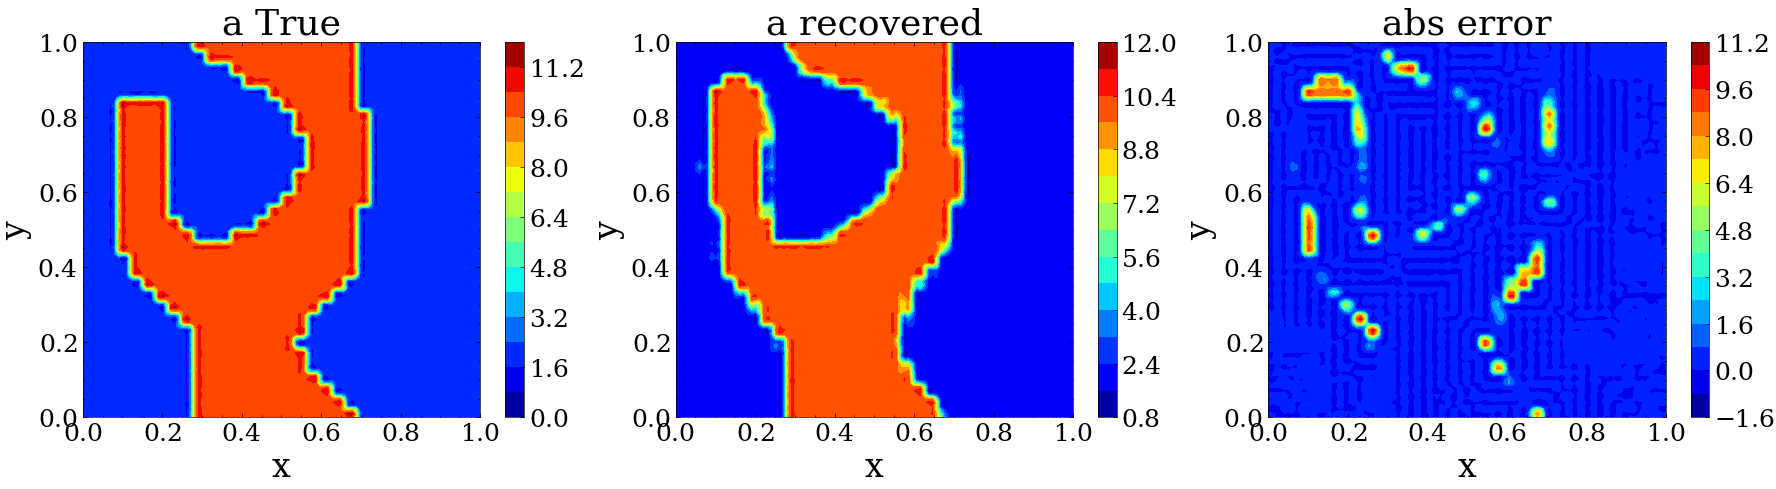

In [4]:
model_beta = torch.load(f'saved_models/DGNO_{tag}/{task}/'+f'model_dgno_inverse.pth')
################################## make prediction
with torch.no_grad():
    x_var = x_in.repeat((1, 1, 1)).to(device)
    beta_pred = model_beta(torch.ones((1,1)).to(device))
    print('x_var', x_var.shape, 'beta_pred', beta_pred.shape)
    #
    a_prop = nn.Sigmoid()(model_trained['a'](x_var, beta_pred))
    a_pred = a_sample(a_prop).detach().cpu()
    #
    u_pred = model_trained['ux'](x_var, beta_pred)
    u_pred = mollifer_x()(u_pred, x_var).detach().cpu()
#
# print('The test l2 error (u avg):', solver.getError(u_pred, u_true))
print('The test l2 error (a avg):', solver.getError(a_pred, a_in))
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(x_in, [a_in, a_pred, abs(a_pred-a_in)], 
                  ['a True', 'a recovered', 'abs error'], lb=0.)